In [1]:
import numba as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.linalg import eig

# Zadanie 5

In [18]:
def SelectEigValues(eig_vals, numEigVal):
  eig_vals =  [x for x in eig_vals if x > 0] or None
  eig_vals.sort()
  if len(eig_vals)<numEigVal:
    eig_vals.extend(np.zeros((numEigVal-len(eig_vals))))
  else:
    eig_vals = eig_vals[0:numEigVal]
  return eig_vals

def f(i,ksi):
    if i == 0:
        return (1-ksi)/2;
    elif i == 1:
        return (1+ksi)/2;
    else:
        print('[ERROR] Unrecognized function')
        exit(-1)

def g(i,ksi_vec):
    if i == 0:
        return f(0,ksi_vec[0])*f(0,ksi_vec[1])
    elif i == 1:
        return f(1,ksi_vec[0])*f(0,ksi_vec[1]) 
    elif i == 2:
        return f(0,ksi_vec[0])*f(1,ksi_vec[1])
    elif i == 3:
        return f(1,ksi_vec[0])*f(1,ksi_vec[1])
    else:
        print('[ERROR] Unrecognized function')
        exit(-1)

def der1(ii,pl,pn):
    return((g(ii,[pl,pn+delta])-g(ii,[pl,pn-delta]))/(2*delta))
def der2(ii,pl,pn):
    return((g(ii,[pl+delta,pn])-g(ii,[pl-delta,pn]))/(2*delta))

mass = 0.067 #au
omega = 10.0 #meV
au_energy = 27211.6
ab = 0.05292 #nm to Bohr radius
N_min = 2
N_max = 10
L_min = 100
L_max = 500
L_iter = 10
numEigVal = 15
eig_values = np.zeros((N_max-N_min,int((L_max-L_min)/L_iter),numEigVal))

for N in range(N_min,N_max):
  for L in range(L_min,L_max,L_iter):


    n_els = (2*N)**2 #liczba elementów
    n_glob = (2*N+1)**2 #liczba węzłów

    x_nlg = np.concatenate([np.linspace(-L/2,L/2,2*N+1) for i in range(2*N+1)])
    y_nlg = np.repeat(np.linspace(-L/2,L/2,2*N+1),2*N+1)
    nlg = np.empty((n_els,4), dtype = int) #dla każdego elementu 4 węzły
    #mesh = np.empty((2*N+1, 2*N+1))     #[i, j] = [y, x]
    for k in range(n_els): #pętla po elementach
        for i in range(2): 
            nlg[k,i] = k + i + k//(2*N) #dla wezla 1 i 2
            nlg[k,i+2] = nlg[k,i] + 2*N+1 #dla wezla 3 i 4
            
    #trójpunktowa kwadratura gaussa
    a=(L/ab)/(2*N) #w jednostkach atomowych
    p = np.array([-math.sqrt(3/5),0,math.sqrt(3/5)])
    w = np.array([5/9,8/9,5/9])

    #lokalna macierz przekrywania
    s = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            for l in range(3):
                for n in range(3):
                    s[i,j] += (a**2)/4*(w[l]*w[n]*g(j,[p[l], p[n]])*g(i,[p[l], p[n]]))

    delta=0.01
    t = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            for l in range(3):
                for n in range(3):
                    t[i,j] += (1/(2*mass))*(w[l]*w[n]*(der1(j,p[l],p[n])*der1(i,p[l],p[n])+der2(j,p[l],p[n])*der2(i,p[l],p[n])))


    #lokalne macierze przekrywania dla energii potencjalnej są różne dla każdego elementu
    v = np.zeros((n_els,4,4))
    omega=10/au_energy

    for k in range(n_els):
        for i in range(4):
            for j in range(4):
                calka=0
                for l in range(3):
                    for n in range(3):
                        xc=(x_nlg[nlg[k,0]]/ab*(1-p[n])+x_nlg[nlg[k,1]]/ab*(1+p[n]))/2
                        yc=(y_nlg[nlg[k,0]]/ab*(1-p[l])+y_nlg[nlg[k,2]]/ab*(1+p[l]))/2
                        calka=calka+(((xc)**2+(yc)**2)*g(j,[p[l], p[n]])*g(i,[p[l], p[n]]))*w[l]*w[n]
                v[k,i,j]=calka*((a**2)/4)*mass*(omega**2)/2
    S = np.zeros((n_glob, n_glob))
    H = np.zeros((n_glob, n_glob))

    # składamy macierze globalne
    for k in range(n_els):
        for i in range(4):
            for j in range(4):
              S[nlg[k,i],nlg[k,j]] += s[i,j]
              H[nlg[k,i],nlg[k,j]] += t[i,j] + v[k,i,j]

    for i in range(2*N+1):#dolny brzeg
      H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0  
      S[i,i] = 1
      H[i,i] = -1410
    for i in range(2*N*(2*N+1), (2*N+1)*(2*N+1)):#gorny brzeg
      H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0  
      S[i,i] = 1
      H[i,i] = -1410
    for i in range(0, (2*N+1)*(2*N+1),(2*N+1)):#lewy brzeg
      H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0  
      S[i,i] = 1
      H[i,i] = -1410
    for i in range(2*N, (2*N+1)*(2*N+1),(2*N+1)):#prawy brzeg
      H[i,:] =  H[:,i] =   S[i,:] =   S[:,i] = 0  
      S[i,i] = 1
      H[i,i] = -1410


    # rozwiazujemy równanie własne Hc = ESc
    eig_vals, eig_vectors = eig(H, S)
    eig_values[N-N_min,int((L-L_min)/L_iter)]= SelectEigValues(eig_vals.real, numEigVal)

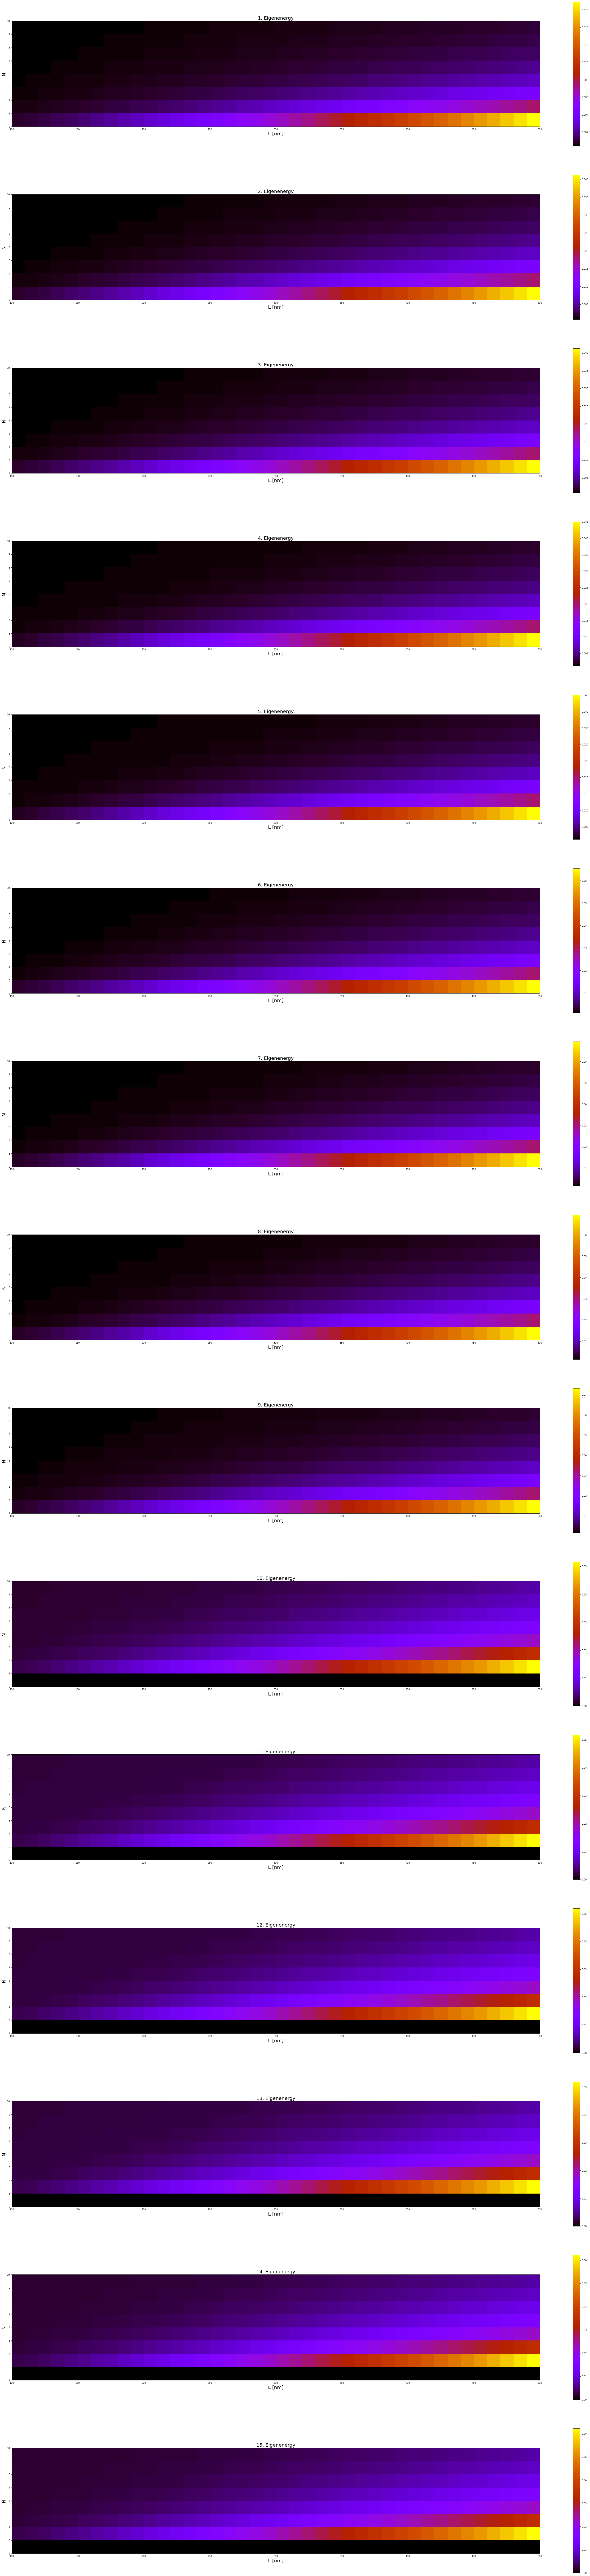

In [19]:
fig, axs = plt.subplots(numEigVal, 1, figsize=(50, 200))


for i in range(numEigVal):
  axs[i].set_title('%i. Eigenenergy' %(i+1), fontsize=20)
  axs[i].set_ylabel('N', fontsize=20)        
  axs[i].set_xlabel('L [nm]', fontsize=20)
  pcm = axs[i].imshow(eig_values[:,:,i], origin='lower', cmap='gnuplot', extent=[L_min,L_max,N_min,N_max], interpolation=None)
  axs[i].set_aspect(L_iter)
  fig.colorbar(pcm, ax=axs[i])